# Задача 2. Реализация обхода в ширину из нескольких стартовых вершин (Multiple-Source BFS)

In [1]:
!sudo add-apt-repository ppa:graphblas/graphblas
!sudo apt-get update
!sudo apt-get install libgraphblas1
!pip install python-graphblas[default]


ERROR: ppa 'graphblas/graphblas' not found (use --login if private)
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [872 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,125 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/

## Задача №1

Используя python-graphblas реализовать функцию обхода ориентированного графа (MSBFS-Levels) в ширину из нескольких заданных стартовых вершин.
- Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин.
- Функция возвращает массив пар: стартовая вершина, и массив (levels), где для каждой вершины указано, на каком уровне она достижима из этой стартовой. Стартовая вершина достижима на нулевом уровне, если вершина не достижима, то значение соответствующей ячейки сделайте равной -1.

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graphblas as gb
from graphblas import Matrix, Vector, Scalar
from graphblas import dtypes
from graphblas import unary, binary, monoid, semiring

import time
import sys
import random
from graphblas.io import mmread

In [88]:
def msbfs_levels(graph, start_vertices):
    n = graph.nrows
    if graph.isequal(graph.T) and graph.nvals > 0:
        raise Exception("Необходим ориентированный граф")

    m = len(start_vertices)
    result = Matrix(dtypes.INT32, m, n)  # Результирующая матрица уровней
    f = Matrix(bool, m, n)  # Матрица фронта
    succ = Vector(bool, m)

    for i in range(m):
        f[i, start_vertices[i]] = True  # Инициализация фронта стартовыми вершинами
    level = 0

    # Обход графа в ширину
    while True:
        result(mask=f.V) << level  # Установка уровня для вершин текущего фронта
        # Вычисление следующего фронта
        f(~result.S, replace=True) << f.mxm(graph, semiring.lor_land)
        for i in range(m):
            # Проверка наличия доступных вершин для каждой из стартовых вершин
            succ[i] << f[i, :].reduce(monoid.lor, allow_empty=True)
        if not any(succ):  # Остановка, если нет новых вершин для обработки
            break
        level += 1

    # Формирование результата
    results = {}
    for i in range(m):
        levels = []
        for j in range(n):
            if result[i, j].value is None:
                levels.append(-1)  # Недостижимая вершина
            else:
                levels.append(result[i, j].value)
        results[start_vertices[i]] = levels

    return results


edges = [
    [3, 0, 3, 5, 6, 0, 6, 1, 6, 2, 4, 1],
    [0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6],
]
graph = Matrix.from_coo(edges[0], edges[1], [True for _ in edges[0]])

start_vertices = [0, 1, 2]
results = msbfs_levels(graph, start_vertices)

for start_vertex, levels in results.items():
    print(f"Стартовая вершина: {start_vertex}, уровни достижимости: {levels}")

Стартовая вершина: 0, уровни достижимости: [0, 1, 2, 1, 2, 3, 2]
Стартовая вершина: 1, уровни достижимости: [3, 0, 2, 2, 1, 2, 1]
Стартовая вершина: 2, уровни достижимости: [-1, -1, 0, -1, -1, 1, -1]


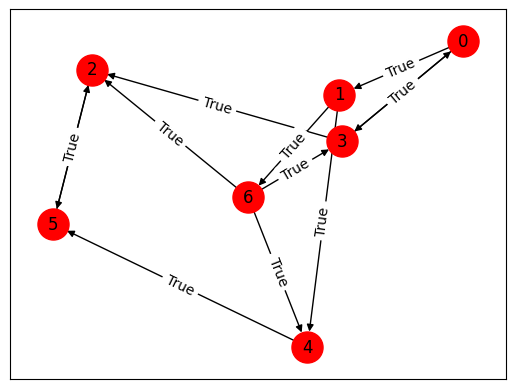

In [89]:
gb.viz.draw(graph)

## Задача №2

Используя python-graphblas реализовать функцию обхода ориентированного графа (MSBFS-Parents) в ширину из нескольких заданных стартовых вершин.
- Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин.
- Функция возвращает массив пар: стартовая вершина, и массив (parents), где для каждой вершины графа указано, из какой вершины мы пришли в эту по кратчайшему пути из стартовой вершины. При этом для самой стартовой вершины такое значение взять равное -1, а для недостижимых вершин взять равное -2. При наличии нескольких возможных значений в массивах parents брать наименьшее.

In [90]:
def msbfs_parents(graph, start_vertices):
    # Проверяем, что граф ориентированный
    n = graph.nrows
    if graph.isequal(graph.T) and graph.nvals > 0:
        raise Exception("Требуется ориентированный граф")

    m = len(start_vertices)

    # Создание матрицы индексов
    index_ramp = Matrix(dtypes.UINT64, m, n)

    for i in range(m):
        for j in range(n):
            index_ramp[i, j] = j

    # Инициализация матриц родителей и волнового фронта
    parents = Matrix(dtypes.UINT64, m, n)
    wavefront = Matrix(dtypes.UINT64, m, n)

    for i in range(m):
        # Заполняем изначальную матрицу строками (по номерам соответствующей вершины)
        parents[i, start_vertices[i]] << start_vertices[i]
        wavefront[i, start_vertices[i]] << 1

    # Обход графа в ширину
    while wavefront.nvals > 0:
        # Преобразуем все сохраненные значения в wavefront в их индекс
        wavefront << index_ramp.ewise_mult(wavefront, binary.first)

        # Маскирование родительского списка
        wavefront(~parents.S, replace=True) << wavefront.mxm(graph, semiring.min_first)

        # Объединение новых родителей в текущий волновой фронт с существующими родителями
        parents(binary.plus) << wavefront

    # Формирование результата
    output = {}
    for i in range(m):
        val = []
        for j in range(n):
            if parents[i, j].value is None:
                val.append(-2)  # Не достигнутая вершина
            elif j == start_vertices[i]:
                val.append(-1)  # Стартовая вершина
            else:
                val.append(parents[i, j].value)
        output[start_vertices[i]] = np.array(val)

    return output

# Пример использования
edges = [
    [3, 0, 3, 5, 6, 0, 6, 1, 6, 2, 4, 1],
    [0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6],
]
graph = Matrix.from_coo(edges[0], edges[1], [True for _ in edges[0]])

start_vertices = [0, 1, 2]
results = msbfs_parents(graph, start_vertices)

for start_vertex, parents in results.items():
    print(f"Стартовая вершина: {start_vertex}, родители: {parents}")


Стартовая вершина: 0, родители: [-1  0  3  0  1  2  1]
Стартовая вершина: 1, родители: [ 3 -1  6  6  1  4  1]
Стартовая вершина: 2, родители: [-2 -2 -1 -2 -2  2 -2]


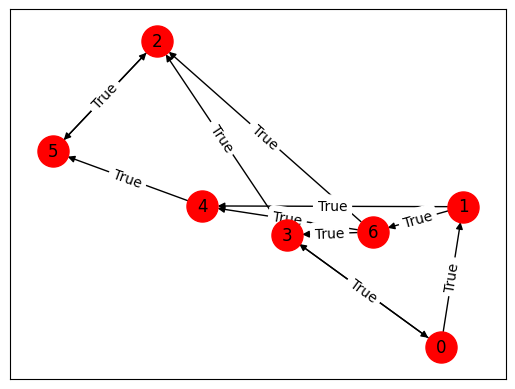

In [91]:
gb.viz.draw(graph)

## Задача №3. Тесты

(MSBFS-Levels) и (MSBFS-Parents)

- неориентированный граф
- граф со связанными вершинами
- граф с вершинами "островками"

### Проверка на Exception

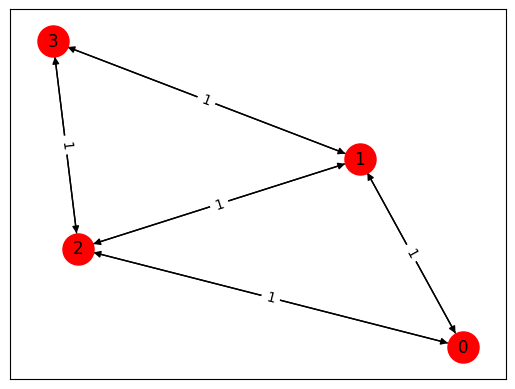

Тест пройден (msbfs_levels)
Тест пройден (msbfs_parents)


In [92]:
def test_undirected_graph():
  matrix1 = np.array([
    [0, 1, 1, 0],
    [1, 0, 1, 1],
    [1, 1, 0, 1],
    [0, 1, 1, 0]
  ])
  M1 = gb.Matrix.from_dense(matrix1, missing_value=0)

  gb.viz.draw(M1)
  start_vertices = [0]

  try:
    msbfs_levels(M1, start_vertices)
    print("Тест не пройден (msbfs_levels)")
  except Exception as e:
    print("Тест пройден (msbfs_levels)")

  try:
    msbfs_parents(M1, start_vertices)
    print("Тест не пройден (msbfs_parents)")
  except Exception as e:
    print("Тест пройден (msbfs_parents)")

test_undirected_graph()

### Проверка с графом со связанными вершинами


- начало в вершинах 0, 1, 3
- старт из 0: вершины 1 и 3 - 1го уровня, 2 - 2го уровня
- старт из 1: вершина 2 - 1го уровня, 3 - 2ого уровня, 0 - недостижима
- старт из 3: вершины 0, 1, 2 - недостижимы

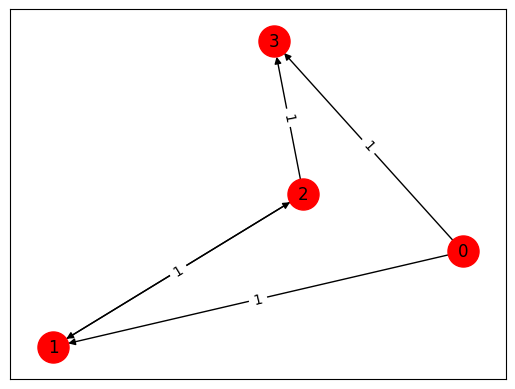

Cвязанный граф (msbfs_levels):
-------------------------------
Стартовая вершина: 0, уровни достижимости: [0, 1, 2, 1]
Стартовая вершина: 1, уровни достижимости: [-1, 0, 1, 2]
Стартовая вершина: 3, уровни достижимости: [-1, -1, -1, 0]
-------------------------------
Cвязанный граф (msbfs_parents):
-------------------------------
Стартовая вершина: 0, родители: [-1  0  1  0]
Стартовая вершина: 1, родители: [-2 -1  1  2]
Стартовая вершина: 3, родители: [-2 -2 -2 -1]


In [93]:
def test_connected_graph():
  matrix2 = np.array([
      [0, 1, 0, 1],
      [0, 0, 1, 0],
      [0, 1, 0, 1],
      [0, 0, 0, 0]
  ])
  graph = gb.Matrix.from_dense(matrix2, missing_value=0)
  gb.viz.draw(graph)

  start_vertices = [0, 1, 3]

  levels_result = msbfs_levels(graph, start_vertices)
  parents_result = msbfs_parents(graph, start_vertices)

  print("Cвязанный граф (msbfs_levels):")
  print("-------------------------------")
  for start_vertex, levels in levels_result.items():
    print(f"Стартовая вершина: {start_vertex}, уровни достижимости: {levels}")
  print("-------------------------------")
  print("Cвязанный граф (msbfs_parents):")
  print("-------------------------------")
  for start_vertex, parents in parents_result.items():
    print(f"Стартовая вершина: {start_vertex}, родители: {parents}")


test_connected_graph()

### Граф с вершинами "островками"

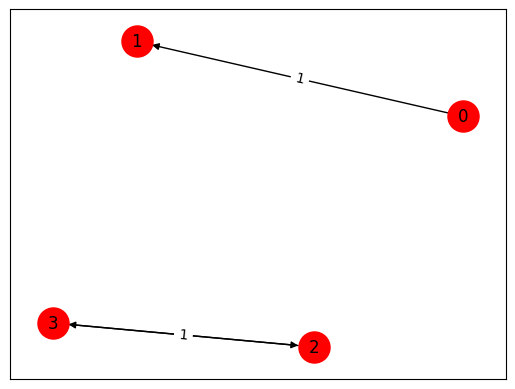

Граф с островками (msbfs_levels):
-------------------------------
Стартовая вершина: 3, уровни достижимости: [-1, -1, 1, 0]
Стартовая вершина: 2, уровни достижимости: [-1, -1, 0, 1]
Стартовая вершина: 1, уровни достижимости: [-1, 0, -1, -1]
-------------------------------
Граф с островками (msbfs_parents):
Стартовая вершина: 3, родители: [-2 -2  3 -1]
Стартовая вершина: 2, родители: [-2 -2 -1  2]
Стартовая вершина: 1, родители: [-2 -1 -2 -2]


In [86]:
def test_island_graph():
  matrix3 = np.array([
      [0, 1, 0, 0],
      [0, 0, 0, 0],
      [0, 0, 0, 1],
      [0, 0, 1, 0]
  ])
  M3 = gb.Matrix.from_dense(matrix3, missing_value=0)

  gb.viz.draw(M3)
  start_vertices = [3, 2, 1]

  levels_result = msbfs_levels(M3, start_vertices)
  parents_result = msbfs_parents(M3, start_vertices)

  print("Граф с островками (msbfs_levels):")
  print("-------------------------------")
  for start_vertex, levels in levels_result.items():
    print(f"Стартовая вершина: {start_vertex}, уровни достижимости: {levels}")
  print("-------------------------------")
  print("Граф с островками (msbfs_parents):")
  for start_vertex, parents in parents_result.items():
    print(f"Стартовая вершина: {start_vertex}, родители: {parents}")

test_island_graph()


## Задача №4

(+2 балла) Провести экспериментальное исследование полученных реализаций на некоторых больших графах в формате Matrix Market с сайта SuiteSparse Matrix Collection и на случайных сгенерированных. При этом описать зависимость времени работы всех полученных реализаций от размеров графа, его степени разреженности, количестве стартовых вершин.

In [11]:
# Функции для тестирования

def gen_vertices(num_vertices, vertex_frac):
    #генерация стартовых вершин в зависимости от числа вершин (num_vertices) и
    #доли (в %) стартовых вершин от общего числа (vertex_frac)
    start_vertices = random.sample(range(num_vertices), int(vertex_frac / 100 * num_vertices))
    return np.array(start_vertices)


# тестирование функции "msbfs_levels"
def test_Levels(A, start_vertices):
    print('msbfs_levels:')
    %timeit msbfs_levels(A, start_vertices)
    print()


# тестирование функции "msbfs_parents"
def test_Parents(A, start_vertices):
    print('msbfs_parents:')
    %timeit msbfs_parents(A, start_vertices)
    print()

In [101]:
graph_names = ['GD00_a', 'Harvard500', 'ibm32'] # названия графов
vertex_fracs=[5, 40, 75, 95] # доли стартовых вершин от общего числа

In [102]:
# Тестирование функции msbfs_levels
# Зависимость времени работы от размера графа (и степени разреженности)
for graph_name in graph_names:
    graph = mmread(f'data/{graph_name}.mtx')
    num_vertices = graph.shape[0]
    num_edges = len(graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(f'Для {graph_name}.mtx (Количество вершин: {num_vertices}, количество ребер: {num_edges}), степень разреженности: {rerefaction_deg:.4f}')

    # Зависимость времени работы от числа стартовых вершин
    for vertex_frac in vertex_fracs:
        print(f'Количество стартовых вершин: {int(vertex_frac / 100 * graph.nrows)}')
        test_Levels(graph, gen_vertices(graph.nrows, vertex_frac))
    print()

Для GD00_a.mtx (Количество вершин: 352, количество ребер: 458), степень разреженности: 0.0037
Количество стартовых вершин: 17
msbfs_levels:
239 ms ± 14.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 140
msbfs_levels:
2.44 s ± 518 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 264
msbfs_levels:
4.93 s ± 1.14 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 334
msbfs_levels:
5.21 s ± 584 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Для Harvard500.mtx (Количество вершин: 500, количество ребер: 2636), степень разреженности: 0.0106
Количество стартовых вершин: 25
msbfs_levels:
927 ms ± 14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 200
msbfs_levels:
8.07 s ± 499 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 375
msbfs_levels:
15.3 s ± 433 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Кол

In [105]:
# Тестирование функции msbfs_parents
# Зависимость времени работы от размера графа (и степени разреженности)
for graph_name in graph_names:
    graph = mmread(f'data/{graph_name}.mtx')
    num_vertices = graph.shape[0]
    num_edges = len(graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(f'Для {graph_name}.mtx (Количество вершин: {num_vertices}, количество ребер: {num_edges}), степень разреженности: {rerefaction_deg:.4f}')

    # Зависимость времени работы от числа стартовых вершин
    for vertex_frac in vertex_fracs:
        if graph_name != 'EPA':
            print(f'Количество стартовых вершин: {int(vertex_frac / 100 * graph.nrows)}')
            test_Parents(graph, gen_vertices(graph.nrows, vertex_frac))
        elif vertex_frac < 50:
            print(f'Количество стартовых вершин: {int(vertex_frac / 100 * graph.nrows)}')
            test_Parents(graph, gen_vertices(graph.nrows, vertex_frac))
    print()

Для GD00_a.mtx (Количество вершин: 352, количество ребер: 458), степень разреженности: 0.0037
Количество стартовых вершин: 17
msbfs_parents:
973 ms ± 314 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 140
msbfs_parents:
3.94 s ± 351 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 264
msbfs_parents:
7.81 s ± 597 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 334
msbfs_parents:
9.66 s ± 361 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Для Harvard500.mtx (Количество вершин: 500, количество ребер: 2636), степень разреженности: 0.0106
Количество стартовых вершин: 25
msbfs_parents:
1.39 s ± 80.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 200
msbfs_parents:
12.1 s ± 288 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 375
msbfs_parents:
22.3 s ± 411 ms per loop (mean ± std. dev. of 7 runs, 1 loop ea

In [106]:
# Тестирование на случайно сгенерированных графах
# Функция генерации случайного графа
def generate_graph(num_vertices, num_edges):
    # Создание множества, состоящего из номеров ячеек матрицы (без диагональных элементов)
    positions = []
    for ind in range(num_vertices**2):
        if ind // num_vertices != ind % num_vertices:
            positions.append(ind)

    # Отбор num_edges случайных индексов вершин (случайные значения из high_positions) для создания ребер
    gen_indices = random.sample(positions, num_edges)

    # Преобразование индексов в координаты (строка, столбец)
    row_indices, col_indices = np.unravel_index(gen_indices, (num_vertices, num_vertices))

    return Matrix.from_coo(row_indices, col_indices, [1]*len(row_indices), nrows=num_vertices, ncols=num_vertices)

In [107]:
# Зависимость от числа вершин (при фиксированной степени разреженности и фиксированном числе стартовых вершин)
for i in [100, 200, 400, 800]:
    fix_raref_deg, num_starts = 0.5, 50  # Фиксированные значения степени разреженности и числа стартовых вершин
    generated_graph = generate_graph(i, int(fix_raref_deg * i * (i-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {num_starts}%')
    test_Levels(generated_graph, gen_vertices(i, num_starts))
    test_Parents(generated_graph, gen_vertices(i, num_starts))

Количество вершин: 100, степень разреженности: 0.50, доля стартовых вершин: 50%
msbfs_levels:
507 ms ± 30.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents:
905 ms ± 396 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 200, степень разреженности: 0.50, доля стартовых вершин: 50%
msbfs_levels:
2.01 s ± 394 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents:
2.78 s ± 428 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 400, степень разреженности: 0.50, доля стартовых вершин: 50%
msbfs_levels:
7.92 s ± 395 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents:
11.2 s ± 425 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 800, степень разреженности: 0.50, доля стартовых вершин: 50%
msbfs_levels:
31.5 s ± 556 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents:
45 s ± 432 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



In [108]:
# Зависимость от степени разреженности (при фиксированном числе вершин и фиксированном числе стартовых вершин)
for i in [0.2, 0.4, 0.6, 0.8]:
    num_vert, num_starts = 500, 50  # Фиксированные число вершин и число стартовых вершин
    generated_graph = generate_graph(num_vert, int(i * num_vert * (num_vert-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {num_starts}%')
    test_Levels(generated_graph, gen_vertices(num_vert, num_starts))
    test_Parents(generated_graph, gen_vertices(num_vert, num_starts))


Количество вершин: 500, степень разреженности: 0.20, доля стартовых вершин: 50%
msbfs_levels:
12.3 s ± 77.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents:
17 s ± 454 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 500, степень разреженности: 0.40, доля стартовых вершин: 50%
msbfs_levels:
12.2 s ± 115 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents:
17.3 s ± 377 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 500, степень разреженности: 0.60, доля стартовых вершин: 50%
msbfs_levels:
12.1 s ± 156 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents:
17.5 s ± 432 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 500, степень разреженности: 0.80, доля стартовых вершин: 50%
msbfs_levels:
12.3 s ± 101 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents:
17.4 s ± 632 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



In [109]:

# Зависимость от числа стартовых вершин (при фиксированном числе вершин и фиксированной степени разреженности)
for i in [20, 40, 60, 80]:
    num_vert, fix_raref_deg = 500, 0.5  # Фиксированные число вершин и значение степени разреженности
    generated_graph = generate_graph(num_vert, int(fix_raref_deg * num_vert * (num_vert-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {i}%')
    test_Levels(generated_graph, gen_vertices(num_vert, i))
    test_Parents(generated_graph, gen_vertices(num_vert, i))

Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 20%
msbfs_levels:
4.91 s ± 446 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents:
7.08 s ± 501 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 40%
msbfs_levels:
9.7 s ± 556 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents:
13.9 s ± 165 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 60%
msbfs_levels:
14.6 s ± 428 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents:
21.1 s ± 575 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 80%
msbfs_levels:
19.6 s ± 629 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents:
27.9 s ± 388 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



## Выводы по тестам

Когда увеличивается количество вершин (при фиксированной степени разреженности 0.5 и доле стартовых вершин 50%), время выполнения обоих алгоритмов также возрастает. Это связано с увеличением количества столбцов в матрицах, что усложняет операцию матричного умножения. Алгоритм msbfs_levels демонстрирует приблизительно линейную зависимость времени от количества вершин, в то время как второй алгоритм показывает более значительное увеличение времени, что указывает на степенную зависимость.

С ростом количества стартовых вершин (при фиксированном числе вершин, равном 500, и степени разреженности 50%) также наблюдается увеличение времени выполнения алгоритмов. В обоих случаях эта зависимость близка к линейной. Это происходит потому, что увеличение числа стартовых вершин напрямую влияет на размерность строк фронта, что усложняет операцию матричного умножения.

При увеличении степени разреженности (уплотнении графа) явной зависимости времени выполнения не наблюдается. Более того, тесты показали, что алгоритмы работают быстрее на графах со средней степенью разреженности. Это можно объяснить тем, что алгоритмы оптимизированы для реальных графов, которые редко бывают почти полными или крайне разреженными.

В сравнении друг с другом, алгоритм msbfs_parents начинает работать медленнее, чем msbfs_levels, по мере увеличения размеров графа.

## Задача №5

 (+3 балла) Добавить реализации описанных алгоритмов с использованием других полуколец (any.pair для levels и any.first для parents). Добавить тесты для проверки корректности. Провести экспериментальное исследование со сравнением этих реализаций с первоначальными на различных графах.

Реализация msbfs_levels с использованием полукольца any.pair

In [3]:
def msbfs_levels_anypair(graph, start_vertices):
    n = graph.nrows
    if graph.isequal(graph.T) and graph.nvals > 0:
        raise Exception("Необходим ориентированный граф")

    m = len(start_vertices)
    result = Matrix(dtypes.INT32, m, n)  # Результирующая матрица уровней
    f = Matrix(bool, m, n)  # Матрица фронта
    succ = Vector(bool, m)

    for i in range(m):
        f[i, start_vertices[i]] = True  # Инициализация фронта стартовыми вершинами
    level = 0

    # Обход графа в ширину
    while True:
        result(mask=f.V) << level  # Установка уровня для вершин текущего фронта
        # Вычисление следующего фронта
        f(~result.S, replace=True) << f.mxm(graph, semiring.any_pair)
        for i in range(m):
            # Проверка наличия доступных вершин для каждой из стартовых вершин
            succ[i] << f[i, :].reduce(monoid.lor, allow_empty=True)
        if not any(succ):  # Остановка, если нет новых вершин для обработки
            break
        level += 1

    # Формирование результата
    results = {}
    for i in range(m):
        levels = []
        for j in range(n):
            if result[i, j].value is None:
                levels.append(-1)  # Недостижимая вершина
            else:
                levels.append(result[i, j].value)
        results[start_vertices[i]] = levels

    return results


Реализация msbfs_parents с использованием полукольца any.first

In [4]:
def msbfs_parents_anyfirst(graph, start_vertices):
    # Проверяем, что граф ориентированный
    n = graph.nrows
    if graph.isequal(graph.T) and graph.nvals > 0:
        raise Exception("Требуется ориентированный граф")

    m = len(start_vertices)

    # Создание матрицы индексов
    index_ramp = Matrix(dtypes.UINT64, m, n)

    for i in range(m):
        for j in range(n):
            index_ramp[i, j] = j

    # Инициализация матриц родителей и волнового фронта
    parents = Matrix(dtypes.UINT64, m, n)
    wavefront = Matrix(dtypes.UINT64, m, n)

    for i in range(m):
        # Заполняем изначальную матрицу строками (по номерам соответствующей вершины)
        parents[i, start_vertices[i]] << start_vertices[i]
        wavefront[i, start_vertices[i]] << 1

    # Обход графа в ширину
    while wavefront.nvals > 0:
        # Преобразуем все сохраненные значения в wavefront в их индекс
        wavefront << index_ramp.ewise_mult(wavefront, binary.first)

        # Маскирование родительского списка
        wavefront(~parents.S, replace=True) << wavefront.mxm(graph, semiring.any_first)

        # Объединение новых родителей в текущий волновой фронт с существующими родителями
        parents(binary.plus) << wavefront

    # Формирование результата
    output = {}
    for i in range(m):
        val = []
        for j in range(n):
            if parents[i, j].value is None:
                val.append(-2)  # Не достигнутая вершина
            elif j == start_vertices[i]:
                val.append(-1)  # Стартовая вершина
            else:
                val.append(parents[i, j].value)
        output[start_vertices[i]] = np.array(val)

    return output


**Функции для тестирования**


In [5]:
def test_Levels_anypair(A, start_vertex):
    print('msbfs_levels_anypair:')
    %timeit msbfs_levels_anypair(A, start_vertex)
    print()

def test_Parents_anyfirst(A, start_vertex):
    print('msbfs_parents_anyfirst:')
    %timeit msbfs_parents_anyfirst(A, start_vertex)
    print()



In [9]:
graph_names = ['GD00_a', 'Harvard500', 'ibm32']  # названия графов
vertex_fracs = [5, 40, 75, 95]  # доли стартовых вершин от общего числа


In [14]:
# Тестирование функции msbfs_levels_anypair
# Зависимость времени работы от размера графа (и степени разреженности)
for graph_name in graph_names:
    graph = mmread(f'data/{graph_name}.mtx')
    num_vertices = graph.shape[0]
    num_edges = len(graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(f'Для {graph_name}.mtx (Количество вершин: {num_vertices}, количество ребер: {num_edges}), степень разреженности: {rerefaction_deg:.4f}')

    # Зависимость времени работы от числа стартовых вершин
    for vertex_frac in vertex_fracs:
        print(f'Количество стартовых вершин: {int(vertex_frac / 100 * graph.nrows)}')
        test_Levels_anypair(graph, gen_vertices(graph.nrows, vertex_frac))
    print()


Для GD00_a.mtx (Количество вершин: 352, количество ребер: 458), степень разреженности: 0.0037
Количество стартовых вершин: 17
msbfs_levels_anypair:
398 ms ± 152 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 140
msbfs_levels_anypair:
2.74 s ± 538 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 264
msbfs_levels_anypair:
4.98 s ± 981 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 334
msbfs_levels_anypair:
6.08 s ± 2.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Для Harvard500.mtx (Количество вершин: 500, количество ребер: 2636), степень разреженности: 0.0106
Количество стартовых вершин: 25
msbfs_levels_anypair:
1.06 s ± 251 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 200
msbfs_levels_anypair:
7.94 s ± 551 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 375
msbfs_levels_anypair:
16.1 s ± 2.12 s 

In [15]:
# Тестирование функции msbfs_parents_anyfirst
# Зависимость времени работы от размера графа (и степени разреженности)
for graph_name in graph_names:
    graph = mmread(f'data/{graph_name}.mtx')
    num_vertices = graph.shape[0]
    num_edges = len(graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(f'Для {graph_name}.mtx (Количество вершин: {num_vertices}, количество ребер: {num_edges}), степень разреженности: {rerefaction_deg:.4f}')

    # Зависимость времени работы от числа стартовых вершин
    for vertex_frac in vertex_fracs:
        print(f'Количество стартовых вершин: {int(vertex_frac / 100 * graph.nrows)}')
        test_Parents_anyfirst(graph, gen_vertices(graph.nrows, vertex_frac))
    print()

Для GD00_a.mtx (Количество вершин: 352, количество ребер: 458), степень разреженности: 0.0037
Количество стартовых вершин: 17
msbfs_parents_anyfirst:
423 ms ± 37.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 140
msbfs_parents_anyfirst:
3.92 s ± 453 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 264
msbfs_parents_anyfirst:
7.25 s ± 457 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 334
msbfs_parents_anyfirst:
8.99 s ± 391 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Для Harvard500.mtx (Количество вершин: 500, количество ребер: 2636), степень разреженности: 0.0106
Количество стартовых вершин: 25
msbfs_parents_anyfirst:
1.95 s ± 795 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 200
msbfs_parents_anyfirst:
11.4 s ± 361 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 375
msbfs_parents_anyfirst:


In [16]:
# Тестирование на случайно сгенерированных графах
def generate_graph(num_vertices, num_edges):
    # Создание множества, состоящего из номеров ячеек матрицы (без диагональных элементов)
    positions = []
    for ind in range(num_vertices**2):
        if ind // num_vertices != ind % num_vertices:
            positions.append(ind)

    # Отбор num_edges случайных индексов вершин (случайные значения из high_positions) для создания ребер
    gen_indices = random.sample(positions, num_edges)

    # Преобразование индексов в координаты (строка, столбец)
    row_indices, col_indices = np.unravel_index(gen_indices, (num_vertices, num_vertices))

    return Matrix.from_coo(row_indices, col_indices, [1]*len(row_indices), nrows=num_vertices, ncols=num_vertices)


In [17]:
# Зависимость от числа вершин (при фиксированной степени разреженности и фиксированном числе стартовых вершин)
for i in [100, 200, 400, 800]:
    fix_raref_deg, num_starts = 0.5, 50  # фиксированные значения степени разреженности и числа стартовых вершин
    generated_graph = generate_graph(i, int(fix_raref_deg * i * (i-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {num_starts}%')
    test_Levels_anypair(generated_graph, gen_vertices(i, num_starts))
    test_Parents_anyfirst(generated_graph, gen_vertices(i, num_starts))


Количество вершин: 100, степень разреженности: 0.50, доля стартовых вершин: 50%
msbfs_levels_anypair:
455 ms ± 14.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents_anyfirst:
614 ms ± 50.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 200, степень разреженности: 0.50, доля стартовых вершин: 50%
msbfs_levels_anypair:
1.91 s ± 287 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents_anyfirst:
2.58 s ± 334 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 400, степень разреженности: 0.50, доля стартовых вершин: 50%
msbfs_levels_anypair:
7.56 s ± 557 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents_anyfirst:
10.8 s ± 311 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 800, степень разреженности: 0.50, доля стартовых вершин: 50%
msbfs_levels_anypair:
30.1 s ± 496 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents_anyfirst:
43.5 s ± 367 ms pe

In [18]:
# Зависимость от степени разреженности (при фиксированном числе вершин и фиксированном числе стартовых вершин)
for i in [0.2, 0.4, 0.6, 0.8]:
    num_vert, num_starts = 500, 50  # фиксированные число вершин и число стартовых вершин
    generated_graph = generate_graph(num_vert, int(i * num_vert * (num_vert-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {num_starts}%')
    test_Levels_anypair(generated_graph, gen_vertices(num_vert, num_starts))
    test_Parents_anyfirst(generated_graph, gen_vertices(num_vert, num_starts))


Количество вершин: 500, степень разреженности: 0.20, доля стартовых вершин: 50%
msbfs_levels_anypair:
11.6 s ± 238 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents_anyfirst:
16.4 s ± 360 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 500, степень разреженности: 0.40, доля стартовых вершин: 50%
msbfs_levels_anypair:
11.8 s ± 17.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents_anyfirst:
16.7 s ± 340 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 500, степень разреженности: 0.60, доля стартовых вершин: 50%
msbfs_levels_anypair:
11.7 s ± 267 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents_anyfirst:
17 s ± 392 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 500, степень разреженности: 0.80, доля стартовых вершин: 50%
msbfs_levels_anypair:
11.7 s ± 234 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents_anyfirst:
16.7 s ± 394 ms per l

In [19]:
# Зависимость от числа стартовых вершин (при фиксированном числе вершин и фиксированной степени разреженности)
for i in [20, 40, 60, 80]:
    num_vert, fix_raref_deg = 500, 0.5  # фиксированные число вершин и значение степени разреженности
    generated_graph = generate_graph(num_vert, int(fix_raref_deg * num_vert * (num_vert-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {i}%')
    test_Levels_anypair(generated_graph, gen_vertices(num_vert, i))
    test_Parents_anyfirst(generated_graph, gen_vertices(num_vert, i))


Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 20%
msbfs_levels_anypair:
4.62 s ± 541 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents_anyfirst:
6.66 s ± 524 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 40%
msbfs_levels_anypair:
9.41 s ± 538 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents_anyfirst:
13.2 s ± 116 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 60%
msbfs_levels_anypair:
14.1 s ± 188 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents_anyfirst:
20.2 s ± 513 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 80%
msbfs_levels_anypair:
18.8 s ± 499 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents_anyfirst:
25.5 s ± 320 ms per 

## Выводы

**Levels**: В случаях, когда графы малы по размеру, имеют очень высокую или очень низкую степень разреженности, или когда количество стартовых вершин невелико, алгоритм на исходном полукольце показывает лучшие результаты по времени выполнения. Однако, при увеличении плотности графа, его размеров и числа стартовых вершин (что ближе к реальным практическим задачам), использование полукольца any_pair приводит к снижению времени выполнения.


**Parents**: По мере приближения характеристик графов к реальным задачам, алгоритм с использованием полукольца any_first демонстрирует сравнимую производительность с исходным полукольцом при малых значениях. Это связано с тем, что выбор первого элемента или поиск минимального элемента могут быть эффективными стратегиями в разных сценариях. При выборе первого подходящего элемента стратегия оказывается более эффективной при большом числе подходящих вариантов. Однако, при увеличении количества стартовых вершин, исходное полукольцо показывает значительно лучшую производительность, что, вероятно, связано с оптимизированной схемой выбора минимального элемента.